In [1]:
from __future__ import print_function, division

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting
import cmocean


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# read in datasets

In [16]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
run_name = 'normal'


month_ds_dict = {} 

for month in months: 
    month_ds_dict[month] = xr.open_dataset(f'../output/{month}_{run_name}_ds')

# Define constants

In [17]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076

times = month_ds_dict[month].time.values


# Column Temperature Difference (Doubled-Base)

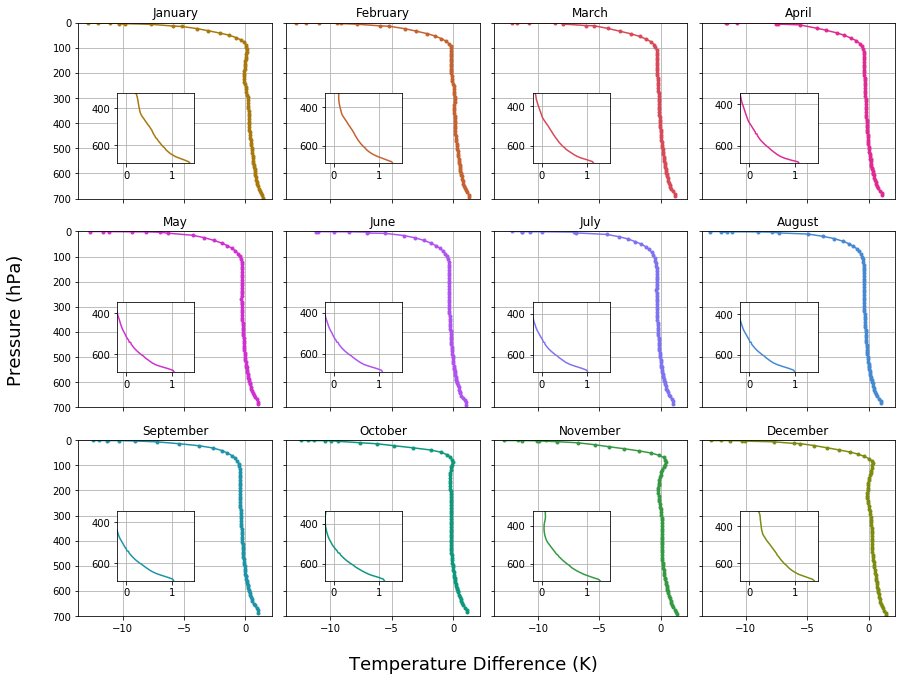

In [30]:
t = times[-1]

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

color = iter(cmocean.cm.phase(np.linspace(0,1,len(months)+1)))

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,9), sharex = True, sharey = True)
axes_list = [item for sublist in axes for item in sublist] 
for month in months:
    c = next(color)
    ax = axes_list.pop(0)
    x1 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1, time = t)['T']
    x2 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc2, time = t)['T']
    y =  month_ds_dict[month].lev_full
    ax.plot(x2-x1, y, marker = '.', label = 'Temperature', c = c)
    ax.set_title(month)
    ax.set_ylim(700,0)
    ax.grid()
    
    #inset axes
    axins = ax.inset_axes([.2,.2, .4,.4])
    axins.plot((x2-x1)[-40:], y[-40:], c = c)
    axins.set_ylim(y[-40:].max(),y[-40:].min())
    axins.set_xlim(-.2,1.5)
    axins.grid()

    
    
    plt.tight_layout()
fig.text(0.5, -0.04, 'Temperature Difference (K)', ha='center', fontsize = 18)
fig.text(-0.04, 0.5, 'Pressure (hPa)', va='center', rotation='vertical', fontsize = 18)
#plt.suptitle(r'Temperature Difference (Double CO$_2$-Base CO$_2$)',fontsize = 20, y = 1.03);
plt.savefig('../figures/temp_dif.png', dpi = 150, bbox_inches = 'tight')

# Surface CO2 Effect

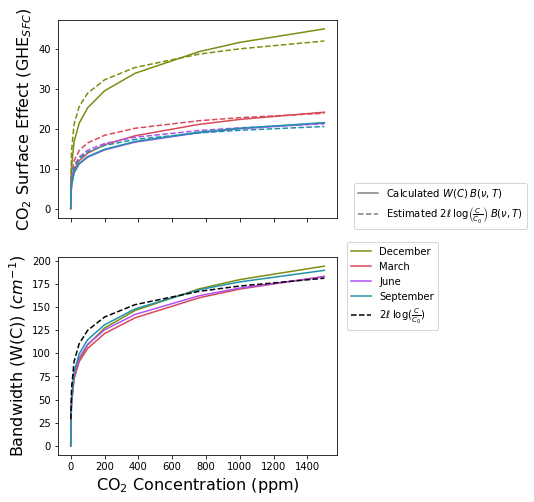

In [28]:
cmap = cmocean.cm.phase(np.linspace(0,1,len(months)+1))
colors_dict = {'December':cmap[11],'March':cmap[2], 'June':cmap[5], 'September':cmap[8]}
ppm_convert = 1e6

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(5,8))
for month in colors_dict.keys():
    c = colors_dict[month]
    
#### plot our co2 surface effect ####
    x = month_ds_dict[month].co2_lev *ppm_convert
    y = month_ds_dict[month]['sfc_co2_effect']
    ax1.plot(x,y,
        label = month, 
        color = c)
    #plt.xscale('log')
    ax1.plot(x, month_ds_dict[month]['sfc_co2_estimate'],
        color = c, linestyle = '--')

#### plot our effective bandwidth ####
    x = month_ds_dict[month].co2_lev *ppm_convert
    y = month_ds_dict[month]['eff_bandwidth']
    ax2.plot(x,y,
        label = month, 
        color = c)
    #plt.xscale('log')
ax2.plot(x[1:], month_ds_dict[month]['eff_bandwidth_est'],
            label = r'$2 \ell  \; \log(\frac{C}{C_0})$',
        color = 'k', linestyle = '--')

ax2.set_xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
ax2.set_ylabel(r'Bandwidth (W(C)) ($cm^{-1}$)', fontsize = 16)
ax2.legend(bbox_to_anchor = [1.38, 1.1]);

#ax1.set_xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
ax1.set_ylabel(r'CO$_2$ Surface Effect (GHE$_{SFC})$', fontsize = 16)

line = Line2D([0,1],[0,1],linestyle='-', color='grey')
dots = Line2D([0,1],[0,1],linestyle='--', color='grey')

ax1.legend([line, dots],[r'Calculated $W(C) \; B(\nu, T)$',r'Estimated $2 \ell \; \log\left(\frac{C}{C_0}\right) \; B(\nu, T)$ '], bbox_to_anchor = [1.7, 0.2])
#plt.savefig('../figures/sfc_bandwidth_and_co2.png', dpi = 150, bbox_inches = 'tight')

# GHE (Surface and TOA)

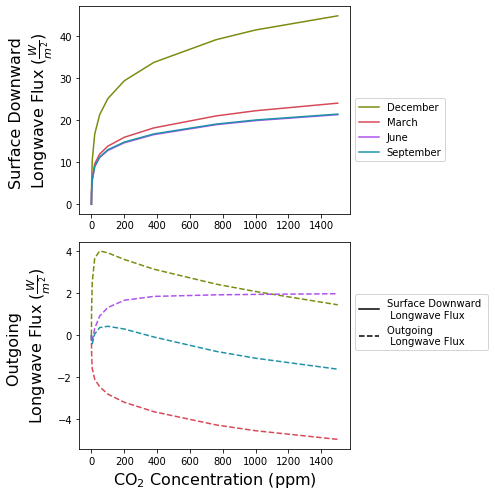

In [21]:
cmap = cmocean.cm.phase(np.linspace(0,1,len(months)+1))
colors_dict = {'December':cmap[11],'March':cmap[2], 'June':cmap[5], 'September':cmap[8], 'January':cmap[0], 'February':cmap[1], 'November':cmap[9]}

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (7,7))
for month in ['December','March','June','September']:
    c = colors_dict[month]
    #sfc longwave plot
    x = month_ds_dict[month].co2_lev *1e6
    y = month_ds_dict[month]['sfc_co2_effect']
    ax1.plot(x,y,
        label = month, 
        color = c)
    #OLR plot
    x = month_ds_dict[month].co2_lev *1e6
    y = (month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])
    ax2.plot(x, y,
            label = month, 
             color = c, 
             linestyle = '--')
    
#set up labels
ax1.set_ylabel('Surface Downward \n' r'Longwave Flux ($\frac{W}{m^2}$)', fontsize = 16)
ax2.set_xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
ax2.set_ylabel('Outgoing \n' r'Longwave Flux ($\frac{W}{m^2}$)', fontsize = 16)

#set up legends
ax1.legend(bbox_to_anchor = [1.37, 0.58]);

line = Line2D([0,1],[0,1],linestyle='-', color='k')
dots = Line2D([0,1],[0,1],linestyle='--', color='k')

ax2.legend([line, dots],['Surface Downward \n Longwave Flux','Outgoing \n Longwave Flux'], bbox_to_anchor = [1., 0.77])
plt.tight_layout()
#plt.savefig('../figures/GH_sfc_CO2_effect.png', dpi = 150, bbox_inches = 'tight')


# Surface Temperature

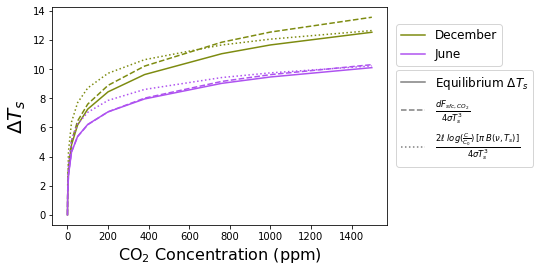

In [43]:
fig, ax1 = plt.subplots()
plot_lines = []
for month in ['December','June']:
    c = colors_dict[month]
    #plot the calculated sfc co2 effect dTs
    y = month_ds_dict[month]['sfc_co2_effect']/(4*5.6E-8*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
    x = month_ds_dict[month]['co2_lev']*ppm_convert
    plot1 = plt.plot(x, y, label = month, linestyle = '--', color = c)
    #plot the model dTs
    y = (month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat')- 
     month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat', co2_lev = 0))
    plot2 = plt.plot(x, y, label = month, linestyle = '-', color = c)
    #plot the estimated sfc co2 effect dTs
    y = month_ds_dict[month]['sfc_co2_estimate']/(4*5.6E-8*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
    plot3 = plt.plot(x, y, label = month, linestyle = ':', color = c)
    #labels
    plt.ylabel(r'$\Delta T_s$', fontsize = 20)
    plt.xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
    plot_lines.append(plot2)
#legends
line = Line2D([0,1],[0,1],linestyle='-', color='grey')
dash = Line2D([0,1],[0,1],linestyle='--', color='grey')
dot =  Line2D([0,1],[0,1],linestyle=':', color='grey')
legend1 = plt.legend([line, dash, dot],[r'Equilibrium $\Delta T_s$',
                                         r'$\frac{dF_{sfc,CO_2}}{4\sigma T_s^3}$', 
                                         r'$\frac{2 \ell \ log(\frac{C}{C_0})\:[\pi\, B(\nu, T_s)]}{4\sigma T_s^3}$'], fontsize = 12, bbox_to_anchor = [1.01, 0.74])
plt.legend([l[0] for l in plot_lines], ['December','June'], fontsize = 12, bbox_to_anchor = [1.01, 0.95])
plt.gca().add_artist(legend1)

#plt.savefig('../figures/delta_Ts.png', dpi = 150, bbox_inches = 'tight')
